# Advanced Tutorial 1: Testing Significance with Monte Carlo SSA

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ADSCIAN/ssalib/blob/main/notebooks/A1_montecarlo_ssa.ipynb)

**Overview** Monte Carlo SSA is used to test the significance of SSA components [[1]](#ref-1). It generates random surrogate copies of the time series decomposed with SSA, preserving the autocorrelation structure of the original series. The matrix of each surrogate time series is projected onto the singular system of the SSA decomposition. For each singular value obtained from the original decomposition, if the value predominantly exceeds the corresponding surrogate-projected values, this singular value can be considered significant. This allows us to reject the null hypothesis that the component results from an autoregressive stochastic process of that order, with the confidence level determined by the distribution of surrogate-projected values.

In this tutorial, you will ll learn:
- How to use `MonteCarloSSA` to evaluate the significance of SSA components.

## Data

* We use the sea surface temperature `sst` time series.

In [1]:
import matplotlib.pyplot as plt
import numpy as np

from ssalib import MonteCarloSSA
from ssalib.datasets import load_sst

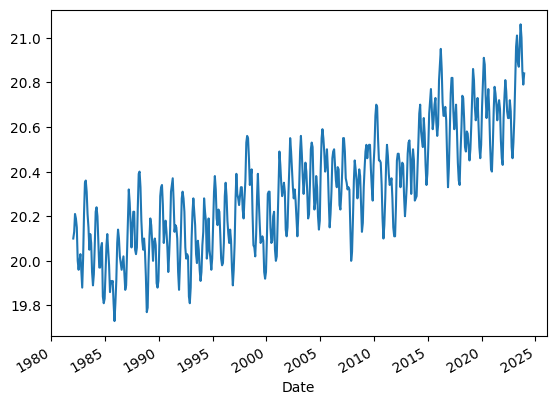

In [2]:
sst = load_sst()
_ = sst.plot()

## Monte Carlos SSA: Initialization

* `MonteCarloSSA` is a child class of `SingularSpectrumAnalysis`.
* During initialization, an autoregressive (AR) model is fitted to the time series.
* The best model up to `ar_order_max` is kept depending on the selected `criterion`, either the Bayesian Information Criterion (`'bic'`) or the Akaike Information Criterion (`'aic'`).
* After fitting, `n_surrogates` surrogate data are generated using the fitted model. Increasing `n_surrogates` makes the test more robust, however, more computationally intensive.
* These surrogates have a similar auto-correlation structure to the original time series, although they are random. Any seemingly cyclical components can be considered spurious and due to the memory (autoregressive coefficients) of the time series.
* A `random_seed` can be provided to ensure the reproducibility of the results.

**Notes**
- The original paper about MonteCarlo SSA used AR1 process (i.e., an autoregressive model of order 1).
- The process can be computationally intensive, especially for long time series.

In [3]:
# Monte Carlo SSA
mcssa = MonteCarloSSA(
    sst,
    svd_solver='sklearn_randomized',
    ar_order_max=1,  # default
    criterion='bic',  # default
    n_surrogates=100,  # default
    random_seed=0
)

### AR Model Results

* The models being fitted is a [`statsmodels.tsa.statespace.sarimax.SARIMAX`](https://www.statsmodels.org/stable/generated/statsmodels.tsa.statespace.sarimax.SARIMAX.html) instance, although only considering AR components in the model.
* We can access the [`SARIMAXResults`](https://www.statsmodels.org/stable/generated/statsmodels.tsa.statespace.sarimax.SARIMAXResults.html) instance with the `MontecarloSSA.autoregressive_model` attribute.

**Notes**
Why SARIMAX?
* SARIMAX is a flexible model that can be used to fit an AR process.
* SARIMAX statsmodels implementation relies on the state space modelling, which make it possible to fit a series containing missing values.

* Accordingly, statmodels SARIMAX is one of the most versatile option, considering possible SSALib future developments.

In [4]:
mcssa.autoregressive_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  504
Model:               SARIMAX(1, 0, 0)   Log Likelihood                -204.061
Date:                Tue, 26 Nov 2024   AIC                            412.122
Time:                        14:23:50   BIC                            420.567
Sample:                             0   HQIC                           415.435
                                - 504                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9346      0.017     54.834      0.000       0.901       0.968
sigma2         0.1310      0.011     12.406      0.000       0.110       0.152
===================================================================================
Ljung-Box (L1) (Q):                 114.26   Jarque-Bera (JB):                14.15
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.02   Skew:                             0.13
Prob(H) (two-sided):                  0.89   Kurtosis:                         2.22
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Surrogate Generation Results
* After, fitting the surrogates are generated using [`statsmodels.tsa.arima_process.arma_generate_sample`](https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima_process.arma_generate_sample.html).
* We can access the surrogates with the `MonteCarloSSA.surrogates` attribute.
* The surrogate array has shape (`n_surrogates`, `len(sst)`).

Surrogate array shape: (100, 504)


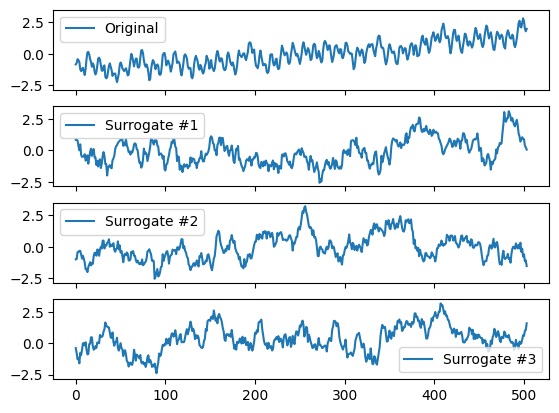

In [5]:
print("Surrogate array shape:", mcssa.surrogates.shape)
# Visualization of the first three surrogates
fig, axes = plt.subplots(4, 1, sharex=True, sharey=True)
axes[0].plot(mcssa['ssa_preprocessed'].values, label='Original')
axes[0].legend()
for i in range(1, 4):
    axes[i].plot(mcssa.surrogates[i], label=f'Surrogate #{i}')
    axes[i].legend()

## Significance Testing
After decomposition,
* the `MonteCarloSSA.plot(kind='values')` method is modified to show the distribution of the surrogates.
* We can pass the `confidence_level` argument to
* By default, the projected values are symetric (two-tailed), meaning that for a confidence level of 0.95, the interval is bound at percentile 2.5 and 97.5.
* On can disable the

### Test against AR1 Surrogates

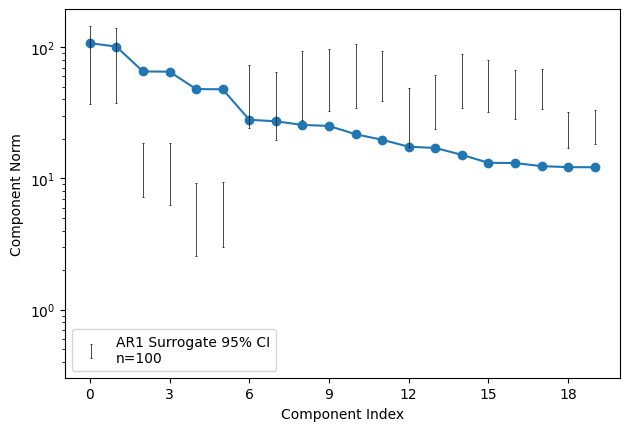

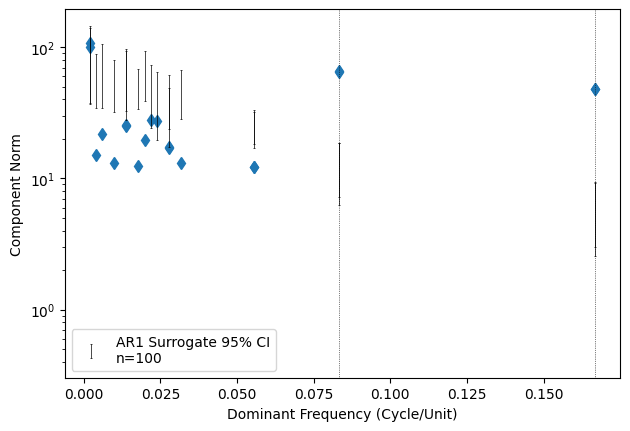

In [6]:
mcssa.decompose(n_components=20)
fig, ax = mcssa.plot(n_components=20, confidence_level=.95, marker='o')
fig, ax = mcssa.plot(
    n_components=20,
    rank_by='freq',
    confidence_level=.95,
    marker='d',
    ls='None'
)
_ = ax.axvline(1 / 12, color='k', lw=.5, ls=':')  # annual freq
_ = ax.axvline(2 / 12, color='k', lw=.5, ls=':')  # semi-annual freq

In [7]:
is_significant = mcssa.test_significance(confidence_level=.95)
significant_indices = [int(i) for i in np.where(is_significant)[0]]

groups = {
    'signal': significant_indices
}
mcssa.reconstruct(groups)

MonteCarloSSA(timeseries=<Series shape=(504,)>, window=252, svd_matrix='SSAMatrixType.BK_TRAJECTORY', svd_solver='sklearn_randomized', standardize=True)

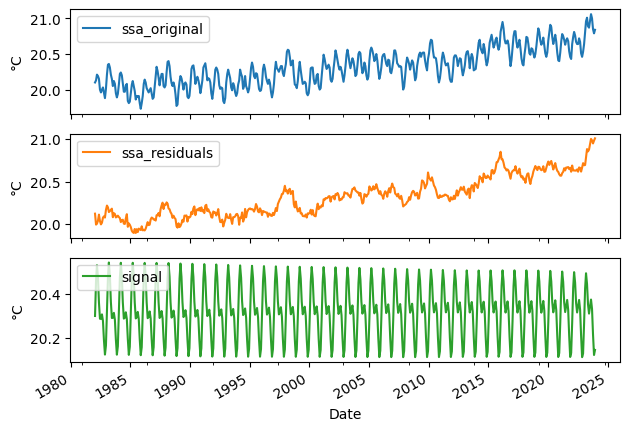

In [8]:
fig, axes = mcssa.plot(
    kind='timeseries',
    include=['ssa_original', 'signal', 'ssa_residuals'],
    rescale=True,
    ylabel='°C',
    subplots=True
)

### Test Against AR0 (White Noise) Surrogates

* If `ar_order_max` is set to zero, the surrogates will be white noise (AR0).
* In that case, the trend captured by eigenvector #0 and #1 appears as significantly different from what would be observed in white noise.


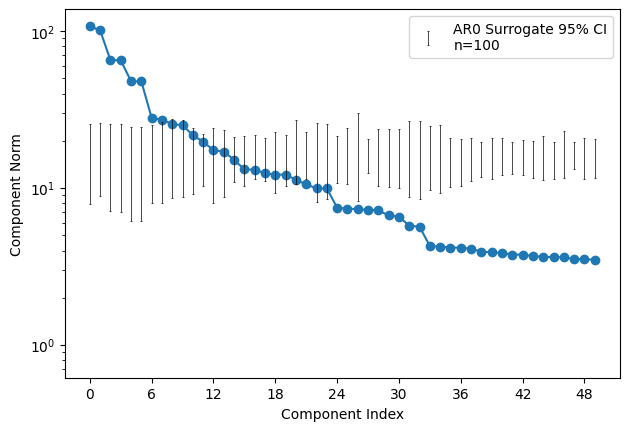

In [9]:
# Monte Carlo SSA
mcssa = MonteCarloSSA(
    sst,
    svd_solver='sklearn_randomized',
    ar_order_max=0,  # AR0
    criterion='bic',  # default
    n_surrogates=100,  # default
    random_seed=0
)
mcssa.decompose(n_components=50)
fig, ax = mcssa.plot(n_components=50, confidence_level=.95, marker='o')

## References

1. <span id='ref-1'></span>Allen, M. R., & Smith, L. A. (1996). Monte Carlo SSA: Detecting irregular oscillations in the Presence of Colored Noise. Journal of Climate, 9(12), 3373–3404.
   [https://doi.org/10.1175/1520-0442(1996)009<3373:MCSDIO>2.0.CO;2](https://doi.org/10.1175/1520-0442(1996)009<3373:MCSDIO>2.0.CO;2)